In [1]:
pip install pandas numpy scikit-learn matplotlib xgboost

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/11.3 MB 7.5 MB/s eta 0:00:02
   ----- ---------------------------------- 1.6/11.3 MB 7.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.6/11.3 MB 7.7 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/11.3 MB 2.5 MB/s eta 0:00:04
   ------ --------------------------------- 1.8/11.3 MB 2.5 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/11.3 MB 1.8 MB/s eta 0:00:06
   -------- ------------------------------- 2.4/11.3 MB 1.6 MB/s eta 0:00:06
   -------- ------------------------------- 2.4/11.3 MB 1.6 MB/s eta 0:00:06
   --------- ------------------------------ 2.6/11.3 MB 1.4 MB/s eta 0:00:07
   ---------- ---------------------

In [3]:
pip install requests


   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   -------- ------------------------------- 1/5 [idna]
   ---------------- ----------------------- 2/5 [charset_normalizer]
   -------------------------------- ------- 4/5 [requests]
   ---------------------------------------- 5/5 [requests]

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
# Download the dataset if you haven't already
import requests
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
response = requests.get(url)
with open("car_fuel_efficiency.csv", "wb") as f:
    f.write(response.content)
# Load the dataset
df = pd.read_csv('car_fuel_efficiency.csv')
# Fill missing values with zeros
df = df.fillna(0)
# Split the data into features and target
X = df.drop('fuel_efficiency_mpg', axis=1)
y = df['fuel_efficiency_mpg']
# Split into train/validation/test with 60%/20%/20% distribution
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2
# Convert dataframes to dictionaries
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')
test_dicts = X_test.to_dict(orient='records')
# Use DictVectorizer to convert dictionaries to matrices
dv = DictVectorizer(sparse=True)
X_train_sparse = dv.fit_transform(train_dicts)
X_val_sparse = dv.transform(val_dicts)
X_test_sparse = dv.transform(test_dicts)
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Train set size: 5822
Validation set size: 1941
Test set size: 1941


In [5]:
# Train a decision tree regressor with max_depth=1
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train_sparse, y_train)
# Get feature names from DictVectorizer
feature_names = dv.get_feature_names_out()
# Get feature importances
importances = dt.feature_importances_
# Create a dictionary of feature importances
feature_importance = dict(zip(feature_names, importances))
# Sort features by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("Feature importances:")
for feature, importance in sorted_features:
    if importance > 0:
        print(f"{feature}: {importance:.4f}")
# The feature with the highest importance is the one used for splitting
split_feature = sorted_features[0][0]
print(f"\nFeature used for splitting: {split_feature}")

Feature importances:
vehicle_weight: 1.0000

Feature used for splitting: vehicle_weight


In [6]:
# Train a random forest regressor
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train_sparse, y_train)
# Make predictions on validation data
y_val_pred = rf.predict(X_val_sparse)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE on validation data: {rmse:.3f}")

RMSE on validation data: 0.460


n_estimators=10, RMSE=0.460
n_estimators=20, RMSE=0.454
n_estimators=30, RMSE=0.452
n_estimators=40, RMSE=0.449
n_estimators=50, RMSE=0.447
n_estimators=60, RMSE=0.445
n_estimators=70, RMSE=0.445
n_estimators=80, RMSE=0.445
n_estimators=90, RMSE=0.445
n_estimators=100, RMSE=0.445
n_estimators=110, RMSE=0.444
n_estimators=120, RMSE=0.444
n_estimators=130, RMSE=0.444
n_estimators=140, RMSE=0.443
n_estimators=150, RMSE=0.443
n_estimators=160, RMSE=0.443
n_estimators=170, RMSE=0.443
n_estimators=180, RMSE=0.442
n_estimators=190, RMSE=0.442
n_estimators=200, RMSE=0.442


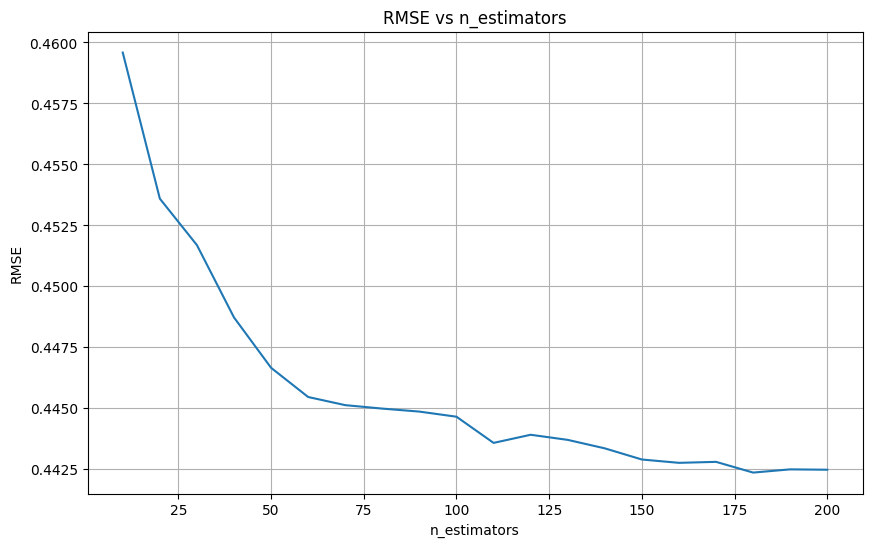

RMSE stops improving after n_estimators=60


In [7]:
# Try different values of n_estimators
n_estimators_values = range(10, 201, 10)
rmse_scores = []
for n_estimators in n_estimators_values:
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    rf.fit(X_train_sparse, y_train)
    
    y_val_pred = rf.predict(X_val_sparse)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    rmse_scores.append(rmse)
    
    print(f"n_estimators={n_estimators}, RMSE={rmse:.3f}")

# Plot RMSE vs n_estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs n_estimators')
plt.grid(True)
plt.show()
# Find where RMSE stops improving (within 3 decimal places)
for i in range(1, len(rmse_scores)):
    if round(rmse_scores[i-1], 3) == round(rmse_scores[i], 3):
        print(f"RMSE stops improving after n_estimators={n_estimators_values[i-1]}")
        break
else:
    print("RMSE continues to improve until the last iteration")

In [8]:
# Try different values of max_depth
max_depth_values = [10, 15, 20, 25]
mean_rmse_scores = {}
for max_depth in max_depth_values:
    rmse_scores = []
    
    for n_estimators in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train_sparse, y_train)
        
        y_val_pred = rf.predict(X_val_sparse)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        rmse_scores.append(rmse)
    
    mean_rmse = np.mean(rmse_scores)
    mean_rmse_scores[max_depth] = mean_rmse
    print(f"max_depth={max_depth}, mean RMSE={mean_rmse:.3f}")

# Find the best max_depth
best_max_depth = min(mean_rmse_scores, key=mean_rmse_scores.get)
print(f"\nBest max_depth: {best_max_depth} with mean RMSE={mean_rmse_scores[best_max_depth]:.3f}")

max_depth=10, mean RMSE=0.442
max_depth=15, mean RMSE=0.445
max_depth=20, mean RMSE=0.446
max_depth=25, mean RMSE=0.446

Best max_depth: 10 with mean RMSE=0.442


In [9]:
# Train a random forest regressor
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train_sparse, y_train)
# Get feature importances
feature_importances = rf.feature_importances_
# Create a dictionary of feature importances
feature_importance = dict(zip(feature_names, feature_importances))
# Sort features by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("Top 10 most important features:")
for feature, importance in sorted_features[:10]:
    print(f"{feature}: {importance:.4f}")
# Find the most important feature among the specified ones
important_features = ['vehicle_weight', 'horsepower', 'acceleration', 'engine_displacement']
most_important = None
highest_importance = 0
for feature in important_features:
    # Check if the feature exists directly or as a one-hot encoded feature
    for f, importance in feature_importance.items():
        if feature in f and importance > highest_importance:
            most_important = feature
            highest_importance = importance

print(f"\nMost important feature among the specified ones: {most_important}")

Top 10 most important features:
vehicle_weight: 0.9591
horsepower: 0.0160
acceleration: 0.0115
engine_displacement: 0.0033
model_year: 0.0032
num_cylinders: 0.0023
num_doors: 0.0016
origin=USA: 0.0005
origin=Europe: 0.0005
origin=Asia: 0.0005

Most important feature among the specified ones: vehicle_weight


In [11]:
# Create DMatrix for train and validation
dtrain = xgb.DMatrix(X_train_sparse, label=y_train)
dval = xgb.DMatrix(X_val_sparse, label=y_val)

# Create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'validation')]

# Train XGBoost model with eta=0.3
xgb_params_03 = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

# Dictionary to store evaluation results
evals_result_03 = {}

model_03 = xgb.train(
    xgb_params_03, 
    dtrain, 
    num_boost_round=100, 
    evals=watchlist, 
    verbose_eval=10,
    evals_result=evals_result_03
)

# Get the best RMSE for eta=0.3
best_rmse_03 = min(evals_result_03['validation']['rmse'])
print(f"Best RMSE with eta=0.3: {best_rmse_03:.3f}")

# Train XGBoost model with eta=0.1
xgb_params_01 = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

# Dictionary to store evaluation results
evals_result_01 = {}

model_01 = xgb.train(
    xgb_params_01, 
    dtrain, 
    num_boost_round=100, 
    evals=watchlist, 
    verbose_eval=10,
    evals_result=evals_result_01
)

# Get the best RMSE for eta=0.1
best_rmse_01 = min(evals_result_01['validation']['rmse'])
print(f"Best RMSE with eta=0.1: {best_rmse_01:.3f}")

# Compare the two models
if best_rmse_03 < best_rmse_01:
    print("eta=0.3 leads to better RMSE")
elif best_rmse_01 < best_rmse_03:
    print("eta=0.1 leads to better RMSE")
else:
    print("Both eta values give equal RMSE")

[0]	train-rmse:1.81393	validation-rmse:1.85444
[10]	train-rmse:0.37115	validation-rmse:0.43896
[20]	train-rmse:0.33553	validation-rmse:0.43376
[30]	train-rmse:0.31475	validation-rmse:0.43752
[40]	train-rmse:0.30202	validation-rmse:0.43968
[50]	train-rmse:0.28456	validation-rmse:0.44140
[60]	train-rmse:0.26768	validation-rmse:0.44290
[70]	train-rmse:0.25489	validation-rmse:0.44531
[80]	train-rmse:0.24254	validation-rmse:0.44689
[90]	train-rmse:0.23193	validation-rmse:0.44839
[99]	train-rmse:0.21950	validation-rmse:0.45018
Best RMSE with eta=0.3: 0.433
[0]	train-rmse:2.28944	validation-rmse:2.34561
[10]	train-rmse:0.91008	validation-rmse:0.94062
[20]	train-rmse:0.48983	validation-rmse:0.53064
[30]	train-rmse:0.38342	validation-rmse:0.44289
[40]	train-rmse:0.35343	validation-rmse:0.42746
[50]	train-rmse:0.33998	validation-rmse:0.42498
[60]	train-rmse:0.33054	validation-rmse:0.42456
[70]	train-rmse:0.32202	validation-rmse:0.42503
[80]	train-rmse:0.31667	validation-rmse:0.42563
[90]	train-r